# XGBoost

In [1]:
import polars as pl
import numpy as np
import xgboost as xgb
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
data_dir = Path.home() / "teams/b13-domain-2/ca_data/"

convert_types = [
    (pl.col("month").cast(pl.UInt8)),
    (pl.col("year").cast(pl.UInt16)),
]

X_train = pl.scan_parquet(data_dir / "X_train.parquet")
y_train = pl.scan_parquet(data_dir / "y_train.parquet")

X_test = pl.scan_parquet(data_dir / "X_test.parquet")
y_test = pl.scan_parquet(data_dir / "y_test.parquet")

X_validation = pl.scan_parquet(data_dir / "X_validation.parquet")
y_validation = pl.scan_parquet(data_dir / "y_validation.parquet")

In [3]:
X_validation.head().collect(engine='streaming')

lat,lon,year,month,tdmean,tmax,ndvi,aspect,ppt_log,vpdmax_log,elevation_log,slope_log,landcover_open_water,landcover_perennial_ice_snow,landcover_developed_open_space,landcover_developed_low_intensity,landcover_developed_medium_intensity,landcover_developed_high_intensity,landcover_barren_land,landcover_deciduous_forest,landcover_evergreen_forest,landcover_mixed_forest,landcover_dwarf_scrub,landcover_shrub_scrub,landcover_grassland_herbaceous,landcover_sedge_herbaceous,landcover_lichens,landcover_moss,landcover_pasture_hay,landcover_cultivated_crops,landcover_woody_wetlands,landcover_emergent_herbaceous_wetlands
f64,f64,u16,u8,f64,f64,f64,f64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
32.54167,-117.125,2005,1,1.213032,-0.378534,0.050861,-0.029061,1.318028,-0.858673,NaN,-1.141189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32.54167,-117.125,2005,2,1.130442,-0.379613,0.76864,-0.029061,1.4078,-0.891527,NaN,-1.141189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32.54167,-117.125,2005,3,1.344749,-0.365579,1.30235,-0.029061,0.859512,-0.990115,NaN,-1.141189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32.54167,-117.125,2005,4,1.184019,-0.328875,1.30235,-0.029061,0.053666,-0.737375,NaN,-1.141189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32.54167,-117.125,2005,5,1.737755,-0.13672,0.153647,-0.029061,-0.825672,-1.016418,NaN,-1.141189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Training

In [4]:
xgb_clf = xgb.XGBClassifier(device="cpu")

xgb_clf.fit(X_train, y_train)

/home/gwuwong/private/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/xgboost/data.py:928: UserWarning: Using the default parameters for the polars `LazyFrame.collect`. Consider passing a realized `DataFrame` or `Series` instead.
  warnings.warn(


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cpu'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Results

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

X_train_df = X_train.collect(engine="streaming")
X_test_df = X_test.collect(engine="streaming")
y_train_arr = y_train.collect(engine="streaming").to_numpy().ravel()
y_test_arr = y_test.collect(engine="streaming").to_numpy().ravel()

y_pred = xgb_clf.predict(X_test_df)
y_pred_proba = xgb_clf.predict_proba(X_test_df)[:, 1]

print(f"\nTrain accuracy: {xgb_clf.score(X_train_df, y_train_arr):.4f}")
print(f"Test accuracy: {xgb_clf.score(X_test_df, y_test_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test_arr, y_pred_proba):.4f}")


Train accuracy: 0.9992
Test accuracy: 0.9992

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  41980704
           1       0.37      0.18      0.24     28843

    accuracy                           1.00  42009547
   macro avg       0.69      0.59      0.62  42009547
weighted avg       1.00      1.00      1.00  42009547


Confusion Matrix:
[[41972158     8546]
 [   23777     5066]]

ROC-AUC Score: 0.8177

PR-AUC: 0.1445


### Validation

In [6]:
X_validation_df = X_validation.collect(engine="streaming")
y_validation_arr = y_validation.collect(engine="streaming").to_numpy().ravel()

y_pred = xgb_clf.predict(X_validation_df)
y_pred_proba = xgb_clf.predict_proba(X_validation_df)[:, 1]

print(f"\nValidation accuracy: {xgb_clf.score(X_validation_df, y_validation_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_validation_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_validation_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_validation_arr, y_pred_proba):.4f}")


Validation accuracy: 0.9992

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  35280437
           1       0.01      0.00      0.00     21703

    accuracy                           1.00  35302140
   macro avg       0.50      0.50      0.50  35302140
weighted avg       1.00      1.00      1.00  35302140


Confusion Matrix:
[[35274394     6043]
 [   21652       51]]

ROC-AUC Score: 0.8315



PR-AUC: 0.0063


### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

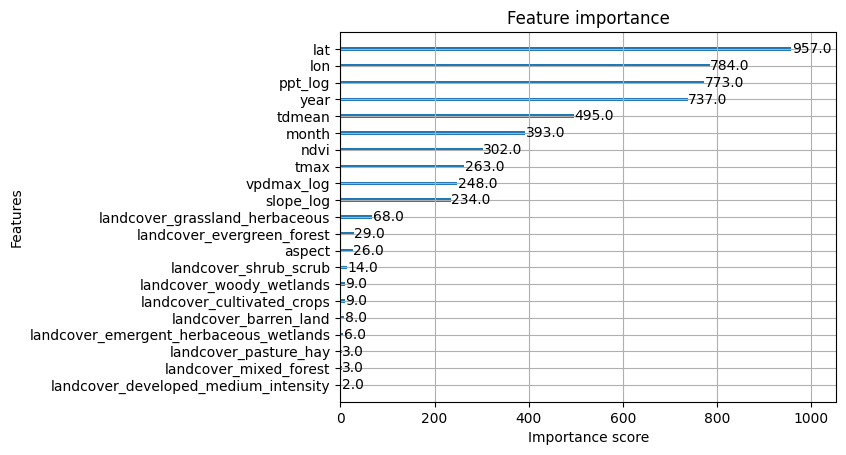

In [10]:
xgb.plot_importance(xgb_clf)

In [ ]:
# 1. Prepare data combining coords, actuals, and predictions
# X_validation_df is already a DataFrame from your previous cell
plot_df = X_validation_df.select(['lat', 'lon']).with_columns([
    pl.Series("Actual", y_validation_arr),
    pl.Series("Predicted_Prob", y_pred_proba)
])

# 2. Group by location to get spatial means (handles time dimension if present)
spatial_comp = plot_df.group_by(['lat', 'lon']).agg([
    pl.col("Actual").mean(),
    pl.col("Predicted_Prob").mean()
])

def plot_actual_vs_predict():
    # Since we started with an eager DataFrame (X_validation_df), spatial_comp is also eager.
    # No need to collect.
    data = spatial_comp
    
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # --- Plot 1: Actual ---
    sc1 = axes[0].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Actual'], 
        cmap='YlOrRd',
        s=10, 
        alpha=0.6
    )
    axes[0].set_title("Actual Fire Distribution (Mean)", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    plt.colorbar(sc1, ax=axes[0], label="Frequency")
    
    # --- Plot 2: Predicted Probability ---
    sc2 = axes[1].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Predicted_Prob'], 
        cmap='YlOrRd',
        s=10, 
        alpha=0.6,
        # Helper to ensure color scales match if you want them absolute
    )
    axes[1].set_title("Predicted Probability (Mean)", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    plt.colorbar(sc2, ax=axes[1], label="Probability")
    
    plt.tight_layout()
    plt.show()

plot_actual_vs_predict()

In [ ]:
# 1. Prepare data including Year and Month
# Ensure X_validation_df has 'year' and 'month' columns (which it should based on your data)
plot_df = X_validation_df.select(['lat', 'lon', 'year', 'month']).with_columns([
    pl.Series("Actual", y_validation_arr),
    pl.Series("Predicted_Prob", y_pred_proba)
])

def plot_comparison_by_date(target_year, target_month):
    # Filter for the specific year and month
    data = plot_df.filter(
        (pl.col("year") == target_year) & 
        (pl.col("month") == target_month)
    )
    
    if data.height == 0:
        print(f"No data found for {target_year}-{target_month}")
        return

    print(f"Plotting for {target_year}-{target_month} (Rows: {data.height})")

    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Common settings
    extent = [data['lon'].min(), data['lon'].max(), data['lat'].min(), data['lat'].max()]
    
    # --- Plot 1: Actual ---
    sc1 = axes[0].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Actual'], 
        cmap='YlOrRd',
        s=15, 
        alpha=0.8,
        vmin=0, vmax=1 # Fix scale for binary/probability comparison
    )
    axes[0].set_title(f"Actual Fire ({target_year}-{target_month})", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    plt.colorbar(sc1, ax=axes[0], label="Class (0 or 1)")
    
    # --- Plot 2: Predicted Probability ---
    sc2 = axes[1].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Predicted_Prob'], 
        cmap='YlOrRd',
        s=15, 
        alpha=0.8,
        vmin=0, vmax=1 # Fix scale to match Actuals
    )
    axes[1].set_title(f"Predicted Probability ({target_year}-{target_month})", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    plt.colorbar(sc2, ax=axes[1], label="Probability")
    
    plt.tight_layout()
    plt.show()

# Example usage: Change these values to look at different months
plot_comparison_by_date(2005, 10) 